train acc로 evaluation method 전환.
각 batch 마다, top k masks에 저장.
exploit시에 top k masks에서 가져오기.

batch별 train, test 구현.
test acc로 evaluation method 전환.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
from torchvision.datasets import CIFAR100
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.nn import functional as F
import sys
import os
import math
import random

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')
print(device)

cuda


In [2]:
# Hyperparameter configurations
exp_num = -1     # To save the result, change every time. -1 to not save.
total_epoch = 200
learning_rate = 0.01
dropout_prob = 0.5
top_k = 10
if exp_num!=-1: os.mkdir(f'./Result{exp_num}')

In [3]:
def dataset_MNIST():
  transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))])
  train_dataset = MNIST(root='../data', train=True, download=True, transform=transform)
  test_dataset = MNIST(root='../data', train=False, download=True, transform=transform)
  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
  test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, drop_last=True)
  return train_loader, test_loader

def dataset_FMNIST():
  transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.2860,), (0.3530,))])
  train_dataset = FashionMNIST(root='../data', train=True, download=True, transform=transform)
  test_dataset = FashionMNIST(root='../data', train=False, download=True, transform=transform)
  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
  test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, drop_last=True)
  return train_loader, test_loader

def dataset_CIFAR10():
  transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
  
  train_dataset = CIFAR10(root='../data', train=True, download=True, transform=transform)
  train_dataset, valid_dataset = random_split(train_dataset, [(len(train_dataset)//5)*4, (len(train_dataset)//5)*1])
  test_dataset = CIFAR10(root='../data', train=False, download=True, transform=transform)

  train_loader = DataLoader(train_dataset, batch_size=40, shuffle=True, drop_last=True)
  valid_loader = DataLoader(valid_dataset, batch_size=10, shuffle=True, drop_last=True)
  test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True, drop_last=True)
  return train_loader, valid_loader, test_loader
  # return train_loader, test_loader

def dataset_CIFAR100():
  transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
  
  train_dataset = CIFAR100(root='../data', train=True, download=True, transform=transform)
  train_dataset, valid_dataset = random_split(train_dataset, [len(train_dataset)//2, len(train_dataset)//2])
  test_dataset = CIFAR100(root='../data', train=False, download=True, transform=transform)

  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
  valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True, drop_last=True)
  test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, drop_last=True)
  return train_loader, test_loader

In [4]:
def Run(dataset, method):
    # Choose dataset
    if dataset=='MNIST': train_loader, test_loader = dataset_MNIST()
    elif dataset=='FMNIST': train_loader, test_loader = dataset_FMNIST()
    elif dataset=='CIFAR10': train_loader, valid_loader, test_loader= dataset_CIFAR10()
    elif dataset=='CIFAR100': train_loader, valid_loader, test_loader = dataset_CIFAR100()
    print(f'Finished loading {dataset} dataset')
    
    # Save log
    if exp_num!=-1:
        sys.stdout = open(f'./Result{exp_num}/{dataset}_{method}.txt', 'w')
        sys.stdout = open(f'./Result{exp_num}/{dataset}_{method}.txt', 'a')
    
    train_acc_list = []
    val_acc_list = []
    train_loss_list = []
    val_loss_list = []
    for epoch in range(total_epoch):
        train_loss, train_correct, val_loss, val_correct = 0,0,0,0
        train_iter = iter(train_loader)
        val_iter = iter(valid_loader)
        for i in range(len(train_loader)):
            # Train
            model.train()
            (data, target) = next(train_iter)
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data, epoch)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (output.argmax(1) == target).sum().item()
            
            # Validation
            model.eval()
            with torch.no_grad():
                (data, target) = next(val_iter)
                data, target = data.to(device), target.to(device)
                output = model(data, epoch)
                loss = criterion(output, target)
                val_loss += loss.item()
                val_correct += (output.argmax(1) == target).sum().item()
                # model.record_acc((output.argmax(1) == target).sum().item())  # EVAL MASK!!!

        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)
        train_acc_list.append(train_accuracy)
        train_loss_list.append(train_loss) 

        val_loss /= len(valid_loader.dataset)
        val_accuracy = val_correct / len(valid_loader.dataset)
        val_acc_list.append(val_accuracy)
        val_loss_list.append(val_loss)

        # Show Result
        print(f'Epoch {epoch + 1:2d} | '
            f'Train Loss: {train_loss:.4f} | Train Accuracy: {round(train_accuracy*100, 2)} | '
            f'Val Loss: {val_loss:.4f} | Val Accuracy: {round(val_accuracy*100, 2)}')
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list


# 그래프
def plot(dataset, method, exp_num):
    figname = f"[{dataset}] {method}  #{exp_num}.svg"
    plt.figure(figsize=(10, 6), dpi=100)
    plt.plot(train_acc_list, label='Train_acc')
    plt.plot(test_acc_list, label='Validation_acc')
    plt.plot(train_loss_list, label='Train_loss')
    plt.plot(test_loss_list, label='Validation_loss')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    if exp_num != -1 : plt.savefig(f'./Result{exp_num}/'+figname, format='svg')
    plt.show()

In [5]:
class SMD(nn.Module):
    def __init__(self, p=0.5, total_epoch=10, k=1):
        super(SMD, self).__init__()
        self.p = p
        self.total_epoch = total_epoch
        self.topk_masks = []
        self.mask = None
        self.accs = []
        self.k = k
        self.using_mask = False

    def forward(self, x, curr_epoch):
        if self.training:
            if curr_epoch <= (self.total_epoch/2):
                self.mask = (torch.rand_like(x) > self.p).float().to(device)
                self.using_mask = False
                x = x * self.mask / (1 - self.p)
                # x = x * self.mask 
                x = x.to(device)
                return x
            elif curr_epoch > (self.total_epoch/2):
                self.mask_idx = self.accs.index(random.choice(self.accs))
                self.mask = self.topk_masks[self.mask_idx]
                self.using_mask = True
                x = x * self.mask / (1 - self.p)
                x.to(device)
                return x
        if not self.training:
            return x

    # 중복마스크 저장하던 오류 제거
    def record_acc(self, acc):
        if len(self.topk_masks) < self.k:
            self.topk_masks.append(self.mask)
            self.accs.append(acc)
        elif len(self.topk_masks) >= self.k:    
            lowest = min(self.accs)
            if self.using_mask == True:
                if acc > lowest:
                    self.accs[self.mask_idx] = acc
            elif self.using_mask == False:
                if acc > lowest:
                    lowest_idx = self.accs.index(lowest)
                    self.topk_masks.pop(lowest_idx)
                    self.accs.pop(lowest_idx)
                    self.topk_masks.append(self.mask)
                    self.accs.append(acc)

In [6]:

class Net_MNIST(nn.Module):
    def __init__(self):
        super(Net_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = nn.Linear(4*4*128, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)
        self.smd1 = SMD(p=dropout_prob, total_epoch=total_epoch, k=top_k)
        self.smd2 = SMD(p=dropout_prob, total_epoch=total_epoch, k=top_k)
    def forward(self, x, curr_epoch):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 4*4*128)
        x = F.relu(self.fc1(x))
        x = self.smd1(x, curr_epoch)
        x = F.relu(self.fc2(x))
        x = self.smd2(x, curr_epoch)
        x = self.fc3(x)
        return x
    def record_acc(self, acc):
        self.smd1.record_acc(acc)
        self.smd2.record_acc(acc)

# Initialize Model
model = Net_MNIST().to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train model
# train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run('MNIST', 'SMD')

In [7]:
# plot('MNIST', 'SMD', exp_num)

In [8]:

class Net_CIFAR10_Drop(nn.Module):
    def __init__(self):
        super(Net_CIFAR10_Drop, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = nn.Linear(5*5*128, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)
        # self.smd1 = SMD(p=dropout_prob, total_epoch=total_epoch, k=top_k)
        # self.smd2 = SMD(p=dropout_prob, total_epoch=total_epoch, k=top_k)
        self.drop1 = nn.Dropout(dropout_prob)
        self.drop2 = nn.Dropout(dropout_prob)

    def forward(self, x, curr_epoch):
        # 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        # 3
        x = x.view(-1, 5*5*128)
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = self.fc3(x)
        return x
    def record_acc(self, acc):
        self.smd1.record_acc(acc)
        self.smd2.record_acc(acc)
        
# Initialize model
model = Net_CIFAR10_Drop().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train model
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run('CIFAR10', 'Drop')

Files already downloaded and verified
Files already downloaded and verified
Finished loading CIFAR10 dataset
Epoch  1 | Train Loss: 0.0566 | Train Accuracy: 14.7 | Val Loss: 0.2262 | Val Accuracy: 16.06
Epoch  2 | Train Loss: 0.0476 | Train Accuracy: 30.67 | Val Loss: 0.1891 | Val Accuracy: 31.52
Epoch  3 | Train Loss: 0.0415 | Train Accuracy: 39.23 | Val Loss: 0.1645 | Val Accuracy: 39.43
Epoch  4 | Train Loss: 0.0379 | Train Accuracy: 44.63 | Val Loss: 0.1503 | Val Accuracy: 45.21
Epoch  5 | Train Loss: 0.0352 | Train Accuracy: 48.82 | Val Loss: 0.1399 | Val Accuracy: 49.2
Epoch  6 | Train Loss: 0.0329 | Train Accuracy: 52.92 | Val Loss: 0.1301 | Val Accuracy: 53.2
Epoch  7 | Train Loss: 0.0306 | Train Accuracy: 56.41 | Val Loss: 0.1220 | Val Accuracy: 56.27
Epoch  8 | Train Loss: 0.0285 | Train Accuracy: 59.56 | Val Loss: 0.1147 | Val Accuracy: 59.97
Epoch  9 | Train Loss: 0.0264 | Train Accuracy: 62.72 | Val Loss: 0.1079 | Val Accuracy: 61.91
Epoch 10 | Train Loss: 0.0247 | Train A

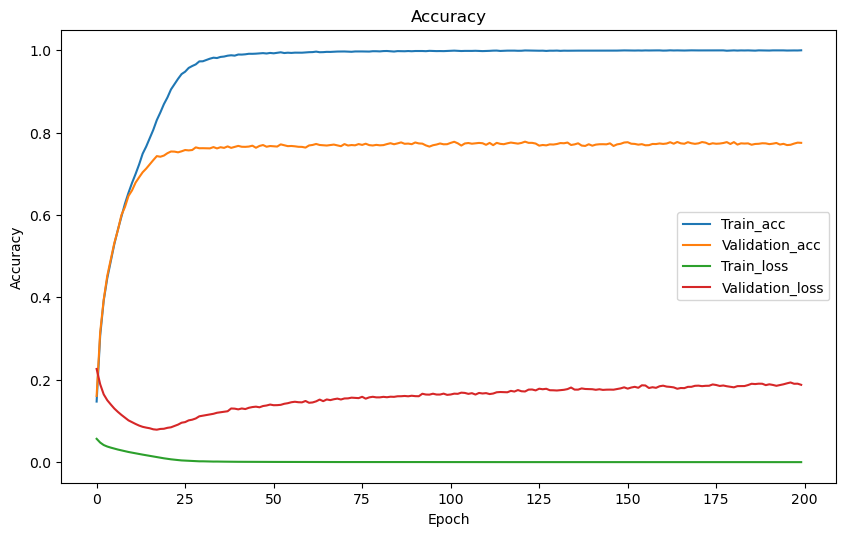

In [9]:
plot('CIFAR10', 'SMD', exp_num)